### **ChatGPT MWP performance prediction**
The emergence of large language models (LLMs) have gained much popularity in recent years, with OpenAI's GPT-3 series models being considered as the state-of-the-art. In particular, the variant of GPT-3 tuned for natural dialog, known as ChatGPT, has gathered much popular interest. However, LLMs have known performance issues, 
specifically when reasoning tasks are involved. This project aims to investigate aspects of math word problems (MWPs) that can indicate the success or failure of ChatGPT on such problems.
  
In this notebook in particular, we attempt to predict ChatGPT's performance on specific questions in DRAW-1K using classifiers by extracting equations from ChatGPT's response.  
  

### **Download libraries**
In order to replicate the results produced in this notebook, it is recommended to use the exact version of Python as well as the exact versions of each library.  
We first download the libraries that will be used in this notebook. We specify the exact version of each library to download.

In [1]:
%%capture

# =========================================== #
#               Requirements
# ------------------------------------------- #
# - Python 3.7.9
# =========================================== #

%pip install nltk==3.8.1
%pip install pandas==1.3.5
%pip install sympy==1.10.1
%pip install plotly==5.13.0
%pip install xgboost==1.6.2

# %pip install xlsxwriter==3.0.9
# %pip install scikit-learn==1.0.2
# %pip install beautifulsoup4==4.11.2
# %pip install torch==1.13.1
# %pip install transformers==4.27.4
# %pip install tqdm==4.64.1

### **Load libraries**

In [2]:
# =========================================== #
#                Libraries
# =========================================== #

# ------------------------------------------- #
#   Python
# ------------------------------------------- #
import re
import os
import ast
import sys
import threading
from time import sleep

try:
    import thread
except ImportError:
    import _thread as thread

# ------------------------------------------- #
#   Pandas
# ------------------------------------------- #
import pandas
pandas.options.display.max_rows = 4000

# ------------------------------------------- #
#   Plotly
# ------------------------------------------- #
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

# ------------------------------------------- #
#   Sympy
# ------------------------------------------- #
from sympy.parsing.sympy_parser import parse_expr
from sympy.parsing.sympy_parser import transformations
from sympy.parsing.sympy_parser import T
from sympy import Eq
from sympy import solve

# ------------------------------------------- #
#   Sklearn
# ------------------------------------------- #
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ------------------------------------------- #
#   Matplotlib
# ------------------------------------------- #
import matplotlib.pyplot as plt

# ------------------------------------------- #
#   XGBoost
# ------------------------------------------- #
from xgboost import XGBClassifier

# ------------------------------------------- #
#   Tensorflow
# ------------------------------------------- #
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

# ------------------------------------------- #
#   Seaborn
# ------------------------------------------- #
import seaborn

### **Constants**
Here, we configure values required one run through of the contents in the notebook.   
This should be the only part of the notebook you would have to change from run-to-run.

In [3]:
RESPONSE_FILE_PATH = '../data/hwelsters__gpt-3.5-turbo__v001 (prefix__system_of_equations).jsonl'
QUESTION_FILE_PATH = '../data/draw.json'
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_SPLITS = 5
VISUALIZE_DATA = True

### **Load data**

In [4]:
# =========================================== #
#                Load data
# =========================================== #

# ------------------------------------------- #
#   Functions which loads data into
#   a dataframe based on its file extension
#   Currently accepts .json, .jsonl, .csv
# ------------------------------------------- #
def load_file(path, usecols):
    split_path = os.path.splitext(path)
    file_extension = split_path[-1]

    data = pandas.DataFrame()
    if file_extension == '.json': data = pandas.read_json(path)
    if file_extension == '.jsonl': data = pandas.read_json(path, lines=True)
    if file_extension == '.csv': data = pandas.read_csv(path)

    return data.columns, data


# ------------------------------------------- #
#   Helper function that loads data stored in 
#   a file at a particular file-path into a 
#   pandas dataframe, extracting only the 
#   columns specified.
# ------------------------------------------- #
def load_data(path, sample_size=5, columns=None, label=None):
    available_columns, dataframe = load_file(path, columns)
    if columns != None: available_columns = list(set(columns).intersection(available_columns))
    return dataframe[available_columns]

In [5]:
# =========================================== #
#           Load ChatGPT's response
# ------------------------------------------- #
# Loads data from input file into a dataframe
# =========================================== #
responses_df = load_data(RESPONSE_FILE_PATH)
responses_df.head()

,model,temperature,max_tokens,date_time,question_number,question,system_text,response,prompt_tokens,completion_tokens,total_tokens
0,gpt-3.5-turbo-0301,1,2048,2023-09-04 08:38:11,5,\nProvide a solution to the following problem ...,None,"{\n 'equations': [\n 'a + c = 34',\n '8...",365,203,568
1,gpt-3.5-turbo-0301,1,2048,2023-09-04 08:38:12,36,\nProvide a solution to the following problem ...,None,"{\n 'equations': [\n 'C = 2G',\n '...",352,176,528
2,gpt-3.5-turbo-0301,1,2048,2023-09-04 08:38:12,16,\nProvide a solution to the following problem ...,None,"{\n 'num_of_unknowns': 2,\n 'num_of_addi...",367,197,564
3,gpt-3.5-turbo-0301,1,2048,2023-09-04 08:38:12,9,\nProvide a solution to the following problem ...,None,"{\n 'equations': [\n 'a - b = 36',\n 'a...",342,186,528
4,gpt-3.5-turbo-0301,1,2048,2023-09-04 08:38:12,6,\nProvide a solution to the following problem ...,None,"{\n 'equations': [\n 'R=1/5',\n 'C=1/6'...",361,240,601


In [6]:
# =========================================== #
#         Load ground truth dataset
# ------------------------------------------- #
# Loads data from input file into a dataframe
# =========================================== #
ground_truth_df = load_data(QUESTION_FILE_PATH)
ground_truth_df.head()

,sQuestion,lSolutions,Template,lEquations,iIndex,Alignment,Equiv
0,Juniors boat will go 15 miles per hour in stil...,[2.14285714286],[a * m + b * m = b * c - a * c],[12*(15-x)=9*(15+x)],397760,"[{'coeff': 'a', 'SentenceId': 1, 'Value': 9.0,...",[]
1,A factory makes three-legged stools and four-l...,"[83.0, 78.0]","[a * m + b * n = c, m + n = d]","[student+general=161, 3*student+4*general=566]",327651,"[{'coeff': 'a', 'SentenceId': 0, 'Value': 3.0,...",[]
2,a bank offers two checking plans . The anywher...,[14.0],[0.01 * a * m - 0.01 * b * m = c],[(.01*30)*x=(.01*22)*x+1.12],238992,"[{'coeff': 'a', 'SentenceId': 1, 'Value': 30.0...",[]
3,The student-teacher ratio for Washington High ...,[1155.0],[a * m = b * c],[27.5*42=x*1],40964,"[{'coeff': 'a', 'SentenceId': 0, 'Value': 1.0,...",[]
4,"Mike 's age , decreased by the age of his 4 ye...","[38.0, 15.0]","[m = a + b, m + n = c]","[y-4=11, y+x=53]",936363,"[{'coeff': 'a', 'SentenceId': 0, 'Value': 4.0,...",[]


### **Convert ChatGPT's JSON response to dict**
ChatGPT will return its answer in JSON form. We will extract the information we require and convert it to dict form.

In [7]:
# =========================================== #
#  Functions for checking ChatGPT's response
# =========================================== #

# ------------------------------------------- #
#   Function to fix ChatGPT's json,
#   Removes comments (e.g '// Comment' --> '')
#   ' symbol if it is between letters (e.g 'Abhinav's' --> 'Abhinavs')
# ------------------------------------------- #
def fixjson(badjson):
    badjson = re.sub(r'\/\/.*\n', '\n', badjson)
    badjson = re.sub(r'([a-zA-Z])\'([a-zA-Z])', '', badjson)
    return badjson

# ------------------------------------------- #
#   Extracts decimals from ChatGPT's str 
#   response. 
#   
#   If ChatGPT's JSON is incorrectly or 
#   unexpectedly formatted, returns "FAILED"
# ------------------------------------------- #
def extract_json(text : str, question_number):
    ret = ""
    try:
        ret = re.findall(r'\{.*\}', text, re.DOTALL)[0]
        ret = fixjson(ret)
        body = ast.literal_eval(fixjson(ret))
        body['question_number'] = question_number
        return body
    except Exception as Argument: 
        return "FAILED"

In [8]:
extracted_json_val = responses_df.apply(lambda x : extract_json(x['response'], x['question_number']), axis=1)
extracted_json_val = extracted_json_val[extracted_json_val!='FAILED'].to_list()
extracted_json_val = pandas.DataFrame(extracted_json_val)
extracted_json_val.head()

,equations,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,steps,final_answer,difficulty,question_number,num_of_multiplication
0,"[a + c = 34, 8a + 5c = 236]",2.0,2.0,0.0,2.0,0.0,2.0,0.0,[Rewrite the given information as a system of ...,[18],4.0,5,NaN
1,"[C = 2G, C - 9 = 5(G - 9)]",2.0,1.0,2.0,1.0,0.0,2.0,2.0,"[Solve the first equation for C, Substitute th...",[36],4.0,36,NaN
2,"[r1 + r2 = d/6, r1 = r2 + 24]",2.0,0.0,1.0,0.0,0.0,1.0,0.0,[1. Substitute r2 + 24 for r1 in the first equ...,"[63, 87]",3.0,16,NaN
3,"[a - b = 36, a + b = 62]",2.0,1.0,1.0,0.0,0.0,2.0,0.0,[Rearrange the equations to solve for one of t...,"[49, 13]",2.0,9,NaN
4,"[R=1/5, C=1/6, T=1/x, R*T + C*T=1, x =(1) / (R...",3.0,2.0,0.0,0.0,1.0,2.0,2.0,[Find the individual rates of Ryan and Castel ...,"[2, 30]",4.0,6,NaN


### **Solve system of equations**
ChatGPT's response will consist of a system of equations. We solve this system of equations so we can compare ChatGPT's final answer to the correct answer.

In [9]:
# ------------------------------------------- #
#   This function standardizes ChatGPT's 
#   equations.
#   
#   e.g 'tons of hay + tons of wheat = 10'
#       --> a + b = 10
#   
#   In some cases, ChatGPT returns a
#   dict of equations
#   In this case, we just get the values or 
#   the keys of this dictionary depending on 
#   which one has an equal sign
# ------------------------------------------- #
def canonicalize_equations(texts):  
    # If ChatGPT did not give equations at all, return None
    if (str(texts) == "nan"): return None

    # CHATGPT sometimes gives equations as dictionaries rather than arrays. 
    # As such, we do this instead
    
    if type(texts) is dict: 
        new_texts = []
        for text in texts.values(): 
            if str(text).count('=') > 0: new_texts.append(text)
        for text in texts.keys(): 
            if str(text).count('=') > 0: new_texts.append(text)
        texts = new_texts

    if type(texts) is list and len(texts) > 0:
        new_texts = []
        for text in texts:
            if type(text) is dict:
                for t in text.values(): 
                    if str(t).count('=') > 0: new_texts.append(t)
                for t in text.keys(): 
                    if str(t).count('=') > 0: new_texts.append(t)
            elif type(text) is str: new_texts.append(text)
        texts = new_texts
        print("NEW TEXT: ", texts)
    
    # Converts it all to a list of str
    if type(texts) is set: texts = list(texts)
    texts = [str(text) for text in texts]


    A_CODE = 97
    letters = {}
    index = A_CODE

    new_texts = []
    for text in texts:
        if type(text) is dict:
            text = text[list(text.values())[0]]
        new_texts.append(text)
    texts = new_texts


    REP = '[supadupaepicstonkifiers]'
    for text in texts:
        text = str(text)
        text = text.replace('+', REP)
        text = text.replace('-', REP)
        text = text.replace('*', REP)
        text = text.replace('=', REP)
        text = text.replace('(', REP)
        text = text.replace(')', REP)
        text = text.replace('{', REP)
        text = text.replace('}', REP)
        text = text.replace(',', '')
        text = text.replace('/', REP)
        text = text.replace('.', REP)

        spl = text.split(REP)

        for text in spl:
            text = text.strip() 
            while len(text) > 0 and text[0].isdigit(): text = text[1:]
            if len(text) > 0 and not text in letters.keys(): 
                letters[text] = chr(index)
                index += 1
    
    to_return = []

    def get_len(key):
        return -len(key[0])

    test_dict_list = list(letters.items())
    test_dict_list.sort(key = get_len)

    letters = {ele[0] : ele[1]  for ele in test_dict_list}

    # Canonicalizes the equation variable names
    for text in texts:
        for swap in letters.keys():
            text = text.replace(swap, letters[swap])
        to_return.append(text)

    return to_return

extracted_json_val["canonicalized_equations"] = extracted_json_val["equations"].apply(lambda row : canonicalize_equations(row))
extracted_json_val.head()

NEW TEXT:  ['a + c = 34', '8a + 5c = 236']
NEW TEXT:  ['C = 2G', 'C - 9 = 5(G - 9)']
NEW TEXT:  ['r1 + r2 = d/6', 'r1 = r2 + 24']
NEW TEXT:  ['a - b = 36', 'a + b = 62']
NEW TEXT:  ['R=1/5', 'C=1/6', 'T=1/x', 'R*T + C*T=1', 'x =(1) / (R + C)']
NEW TEXT:  ['x + 6 = 4x - 30', '3x = 36', 'x = 12']
NEW TEXT:  ['w = 3s', 'w + s = 52']
NEW TEXT:  ['a + b = -42', 'a - b = 52']
NEW TEXT:  ['x = 2y + 4', 'x + y = 25']
NEW TEXT:  ['508 = 6n + 70']
NEW TEXT:  ['p + 2c = 2860', '2p + c = 2990']
NEW TEXT:  ['A = 54,150 + 12.50B', '25A = B*25A']
NEW TEXT:  ['x + y = 13', 'x = 2y + 1']
NEW TEXT:  ['B = Bell age', 'B + (B+9) = 19']
NEW TEXT:  ['A + C = 24', '16A + 9C = 258']
NEW TEXT:  ['m = s + 7', 'm + s = 27']
NEW TEXT:  ['3x + 4y = 566', 'x + y = 161']
NEW TEXT:  ['x + y = 88', 'x = 5y + 10']
NEW TEXT:  ['Accucheck Cost = 1.12 + 0.22x', 'Anywhere Cost = 0.3x']
NEW TEXT:  ['19 + 4n = 166 - 3n']
NEW TEXT:  ['125 - x = 6(80 - x)', '125 - x = 480 - 6x', '5x = 355', 'x = 71']
NEW TEXT:  ['x + y = 40', 

,equations,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,steps,final_answer,difficulty,question_number,num_of_multiplication,canonicalized_equations
0,"[a + c = 34, 8a + 5c = 236]",2.0,2.0,0.0,2.0,0.0,2.0,0.0,[Rewrite the given information as a system of ...,[18],4.0,5,NaN,"[a + b = 34, 8a + 5b = 236]"
1,"[C = 2G, C - 9 = 5(G - 9)]",2.0,1.0,2.0,1.0,0.0,2.0,2.0,"[Solve the first equation for C, Substitute th...",[36],4.0,36,NaN,"[a = 2b, a - 9 = 5(b - 9)]"
2,"[r1 + r2 = d/6, r1 = r2 + 24]",2.0,0.0,1.0,0.0,0.0,1.0,0.0,[1. Substitute r2 + 24 for r1 in the first equ...,"[63, 87]",3.0,16,NaN,"[a + b = c/6, a = b + 24]"
3,"[a - b = 36, a + b = 62]",2.0,1.0,1.0,0.0,0.0,2.0,0.0,[Rearrange the equations to solve for one of t...,"[49, 13]",2.0,9,NaN,"[a - b = 36, a + b = 62]"
4,"[R=1/5, C=1/6, T=1/x, R*T + C*T=1, x =(1) / (R...",3.0,2.0,0.0,0.0,1.0,2.0,2.0,[Find the individual rates of Ryan and Castel ...,"[2, 30]",4.0,6,NaN,"[a=1/5, b=1/6, c=1/d, a*c + b*c=1, d =(1) / (a..."


In [10]:
# ------------------------------------------- #
#   A function for creating a SymPy 
#   expressions
# ------------------------------------------- #
def create_expression(text):
    print(text)
    split_text = text.split('=')
    return Eq(parse_expr(split_text[0], transformations=T[:6]), parse_expr(split_text[1], transformations=T[:6]))

def quit_function(fn_name):
    # print to stderr, unbuffered in Python 2.
    sys.stderr.flush() # Python 3 stderr is likely buffered.
    thread.interrupt_main() # raises KeyboardInterrupt

# ------------------------------------------- #
#   A function that times out functions 
#   after a certain period of time
# ------------------------------------------- #
def exit_after(s):
    '''
    use as decorator to exit process if 
    function takes longer than s seconds
    '''
    def outer(fn):
        def inner(*args, **kwargs):
            timer = threading.Timer(s, quit_function, args=[fn.__name__])
            timer.start()
            try:
                result = fn(*args, **kwargs)
            finally:
                timer.cancel()
            return result
        return inner
    return outer

# ------------------------------------------- #
#   Solves a system of equations given in
#   a list of str
# ------------------------------------------- #
@exit_after(5)
def solve_system(equations):
    try:
        expressions = [create_expression(equation) for equation in equations]
        return solve(expressions)
    except:
        return {}

extracted_json_val["solved_ans"] = extracted_json_val.apply(lambda row : solve_system(row["canonicalized_equations"]), axis=1)
extracted_json_val.head()

a + b = 34
8a + 5b = 236
a = 2b
a - 9 = 5(b - 9)
a + b = c/6
a = b + 24
a - b = 36
a + b = 62
a=1/5
b=1/6
c=1/d
a*c + b*c=1
d =(1) / (a + b)
a + 6 = 4a - 30
3a = 36
a = 12
a = 3b
a + b = 52
a + b = -42
a - b = 52
a = 2b + 4
a + b = 25
508 = 6a + 70
a + 2b = 2860
2a + b = 2990
a + b = 9
10b + a = 6(a + b)
a = 54,150 + 12.50b
25a = b*25a
a + b = 13
a = 2b + 1
a = b
a + (a+9) = 19
a + b = 24
16a + 9b = 258
a = b + 7
a + b = 27
3a + 4b = 566
a + b = 161
a + b = 88
a = 5b + 10
a = 1.12 + 0.22b
c = 0.3b
19 + 4a = 166 - 3a
125 - a = 6(80 - a)
125 - a = 480 - 6a
5a = 355
a = 71
a + b = 40
0.25a + 0.50b = 0.45*40
a - b = 16
3a = 9b
a + b = 6000
0.09a + 0.11b = 624
a + 0.04a = 1058.30
1.04a = 1058.30
3a + b = 14
2a - b = 1
a = 3b
a + 20 = b + 6
a + b = 17
b = 3a
a + b = 7
21a + 14b = 119
a + b = 28
0.05a + 0.10b = 2.60
a = 1/4
b = 1/6
a + b = 1/c
a + b = 55
a - b = -9
a = b
c = d
0.35a + 0.15c = 2640
a + 2600 = c
0.35(a + 2600) + 0.15a = 2640
a = b + 4
10a + b = 3(10b + a) + 6
a + b = 140
a - b 

,equations,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,steps,final_answer,difficulty,question_number,num_of_multiplication,canonicalized_equations,solved_ans
0,"[a + c = 34, 8a + 5c = 236]",2.0,2.0,0.0,2.0,0.0,2.0,0.0,[Rewrite the given information as a system of ...,[18],4.0,5,NaN,"[a + b = 34, 8a + 5b = 236]","{a: 22, b: 12}"
1,"[C = 2G, C - 9 = 5(G - 9)]",2.0,1.0,2.0,1.0,0.0,2.0,2.0,"[Solve the first equation for C, Substitute th...",[36],4.0,36,NaN,"[a = 2b, a - 9 = 5(b - 9)]","{a: 24, b: 12}"
2,"[r1 + r2 = d/6, r1 = r2 + 24]",2.0,0.0,1.0,0.0,0.0,1.0,0.0,[1. Substitute r2 + 24 for r1 in the first equ...,"[63, 87]",3.0,16,NaN,"[a + b = c/6, a = b + 24]","{a: c/12 + 12, b: c/12 - 12}"
3,"[a - b = 36, a + b = 62]",2.0,1.0,1.0,0.0,0.0,2.0,0.0,[Rearrange the equations to solve for one of t...,"[49, 13]",2.0,9,NaN,"[a - b = 36, a + b = 62]","{a: 49, b: 13}"
4,"[R=1/5, C=1/6, T=1/x, R*T + C*T=1, x =(1) / (R...",3.0,2.0,0.0,0.0,1.0,2.0,2.0,[Find the individual rates of Ryan and Castel ...,"[2, 30]",4.0,6,NaN,"[a=1/5, b=1/6, c=1/d, a*c + b*c=1, d =(1) / (a...",[]


In [11]:
# ------------------------------------------- #
#   A function that extracts decimal numbers
#   from string
# ------------------------------------------- #
def extract_decimals(response : str):
    response = str(response)
    pattern = r'\d+(?:\.\d+)?'
    decimals = re.findall(pattern, response)
    return set(decimals)

extracted_json_val["extracted_solved_ans"] = extracted_json_val.apply(lambda row : extract_decimals(row["solved_ans"]), axis=1)
extracted_json_val["extracted_final_answer"] = extracted_json_val.apply(lambda row : extract_decimals(row["final_answer"]), axis=1)
extracted_json_val["final_solved_same"] = extracted_json_val.apply(lambda row : 1 if row["extracted_final_answer"].issubset(row["extracted_solved_ans"])  else 0, axis=1)
extracted_json_val.head()

,equations,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,steps,final_answer,difficulty,question_number,num_of_multiplication,canonicalized_equations,solved_ans,extracted_solved_ans,extracted_final_answer,final_solved_same
0,"[a + c = 34, 8a + 5c = 236]",2.0,2.0,0.0,2.0,0.0,2.0,0.0,[Rewrite the given information as a system of ...,[18],4.0,5,NaN,"[a + b = 34, 8a + 5b = 236]","{a: 22, b: 12}","{12, 22}",{18},0
1,"[C = 2G, C - 9 = 5(G - 9)]",2.0,1.0,2.0,1.0,0.0,2.0,2.0,"[Solve the first equation for C, Substitute th...",[36],4.0,36,NaN,"[a = 2b, a - 9 = 5(b - 9)]","{a: 24, b: 12}","{12, 24}",{36},0
2,"[r1 + r2 = d/6, r1 = r2 + 24]",2.0,0.0,1.0,0.0,0.0,1.0,0.0,[1. Substitute r2 + 24 for r1 in the first equ...,"[63, 87]",3.0,16,NaN,"[a + b = c/6, a = b + 24]","{a: c/12 + 12, b: c/12 - 12}",{12},"{63, 87}",0
3,"[a - b = 36, a + b = 62]",2.0,1.0,1.0,0.0,0.0,2.0,0.0,[Rearrange the equations to solve for one of t...,"[49, 13]",2.0,9,NaN,"[a - b = 36, a + b = 62]","{a: 49, b: 13}","{49, 13}","{49, 13}",1
4,"[R=1/5, C=1/6, T=1/x, R*T + C*T=1, x =(1) / (R...",3.0,2.0,0.0,0.0,1.0,2.0,2.0,[Find the individual rates of Ryan and Castel ...,"[2, 30]",4.0,6,NaN,"[a=1/5, b=1/6, c=1/d, a*c + b*c=1, d =(1) / (a...",[],{},"{2, 30}",0


### **Evaluate ChatGPT's response**
We compare ChatGPT's response to the actual solution and observe how well ChatGPT fared.

In [12]:
# ------------------------------------------- #
#   A helper function for comparing  
#   ChatGPT's response to the actual solution
# ------------------------------------------- #
def evaluate_response(actual_solution, response_solution, transform_func):
    actual_solution = [transform_func(float(solution)) for solution in actual_solution]
    response_solution = [transform_func(float(solution)) for solution in response_solution]

    actual_solution = set(actual_solution)
    response_solution = set(response_solution)
    
    if actual_solution.issubset(response_solution): return "all"
    elif actual_solution.intersection(response_solution): return "some"
    else: return "none"
    
# ------------------------------------------- #
#   Check ChatGPT's response without any 
#   transformations
# ------------------------------------------- #
def check_normal(actual_solution, response_solution):
    return evaluate_response(actual_solution, response_solution, lambda x : x)

# ------------------------------------------- #
#   Check ChatGPT's response when rounded
# ------------------------------------------- #
def check_rounded(actual_solution, response_solution):
    return evaluate_response(actual_solution, response_solution, lambda x : round(x, 1))

evaluated_df = extracted_json_val
evaluated_df['normal_correct'] = evaluated_df.apply(lambda row : check_normal(ground_truth_df.loc[row["question_number"]]["lSolutions"], list(row["extracted_final_answer"])), axis=1)
evaluated_df['rounded_correct'] = evaluated_df.apply(lambda row : check_rounded(ground_truth_df.loc[row["question_number"]]["lSolutions"], list(row["extracted_final_answer"])), axis=1)


# ------------------------------------------- #
#   We also create the y value for prediction
# ------------------------------------------- #

answer_map = {"all": 1, "some" : 0, "none": 0}
evaluated_df['is_correct'] = evaluated_df.apply(lambda row : answer_map[row["normal_correct"]], axis=1)
evaluated_df.head()

,equations,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,steps,final_answer,...,question_number,num_of_multiplication,canonicalized_equations,solved_ans,extracted_solved_ans,extracted_final_answer,final_solved_same,normal_correct,rounded_correct,is_correct
0,"[a + c = 34, 8a + 5c = 236]",2.0,2.0,0.0,2.0,0.0,2.0,0.0,[Rewrite the given information as a system of ...,[18],...,5,NaN,"[a + b = 34, 8a + 5b = 236]","{a: 22, b: 12}","{12, 22}",{18},0,none,none,0
1,"[C = 2G, C - 9 = 5(G - 9)]",2.0,1.0,2.0,1.0,0.0,2.0,2.0,"[Solve the first equation for C, Substitute th...",[36],...,36,NaN,"[a = 2b, a - 9 = 5(b - 9)]","{a: 24, b: 12}","{12, 24}",{36},0,none,none,0
2,"[r1 + r2 = d/6, r1 = r2 + 24]",2.0,0.0,1.0,0.0,0.0,1.0,0.0,[1. Substitute r2 + 24 for r1 in the first equ...,"[63, 87]",...,16,NaN,"[a + b = c/6, a = b + 24]","{a: c/12 + 12, b: c/12 - 12}",{12},"{63, 87}",0,none,none,0
3,"[a - b = 36, a + b = 62]",2.0,1.0,1.0,0.0,0.0,2.0,0.0,[Rearrange the equations to solve for one of t...,"[49, 13]",...,9,NaN,"[a - b = 36, a + b = 62]","{a: 49, b: 13}","{49, 13}","{49, 13}",1,all,all,1
4,"[R=1/5, C=1/6, T=1/x, R*T + C*T=1, x =(1) / (R...",3.0,2.0,0.0,0.0,1.0,2.0,2.0,[Find the individual rates of Ryan and Castel ...,"[2, 30]",...,6,NaN,"[a=1/5, b=1/6, c=1/d, a*c + b*c=1, d =(1) / (a...",[],{},"{2, 30}",0,none,none,0


### **ChatGPT's stats**
We observe how well ChatGPT has done

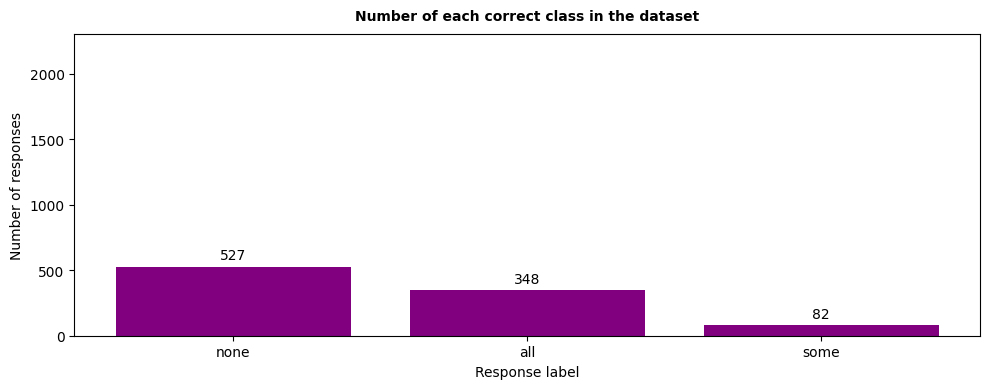

In [13]:
# =========================================== #
#    Visualize normal data
# =========================================== #

if VISUALIZE_DATA:
       fig, ax = plt.subplots(1, 1, figsize=(10, 4))

       # Distribution by class
       ax.bar(x = evaluated_df['normal_correct'].unique(), # Data labels
              height = evaluated_df['normal_correct'].value_counts().values, # Num of tweets in each category
              color='purple')

       ax.bar_label(ax.containers[0], label_type='edge', padding=3) # Annotate bars
       ax.set_ylim(0, 2300) # Raise upper limit of y-axis, to accommodate labels

       ax.set_title("Number of each correct class in the dataset", 
              fontweight='bold', fontsize=10, y = 1.02)
       ax.set_ylabel("Number of responses")
       ax.set_xlabel('Response label')

       plt.tight_layout()
       plt.show()

In [14]:
model_df = evaluated_df[[
    "num_of_unknowns", 
    "num_of_additions", 
    "num_of_subtractions", 
    "num_of_multiplications", 
    "num_of_divisions", 
    "num_of_equations", 
    "num_of_parentheses", 
    "difficulty",
    "is_correct",
]]
model_df = model_df.dropna()
print("Dataframe LEN:" + str(len(model_df)))
model_df.head()

Dataframe LEN:946


,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,difficulty,is_correct
0,2.0,2.0,0.0,2.0,0.0,2.0,0.0,4.0,0
1,2.0,1.0,2.0,1.0,0.0,2.0,2.0,4.0,0
2,2.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0
3,2.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,1
4,3.0,2.0,0.0,0.0,1.0,2.0,2.0,4.0,0


### **Pearson Correlation Heatmap**
We generate some correlation plots of the features to observe correlations between various mathematical features

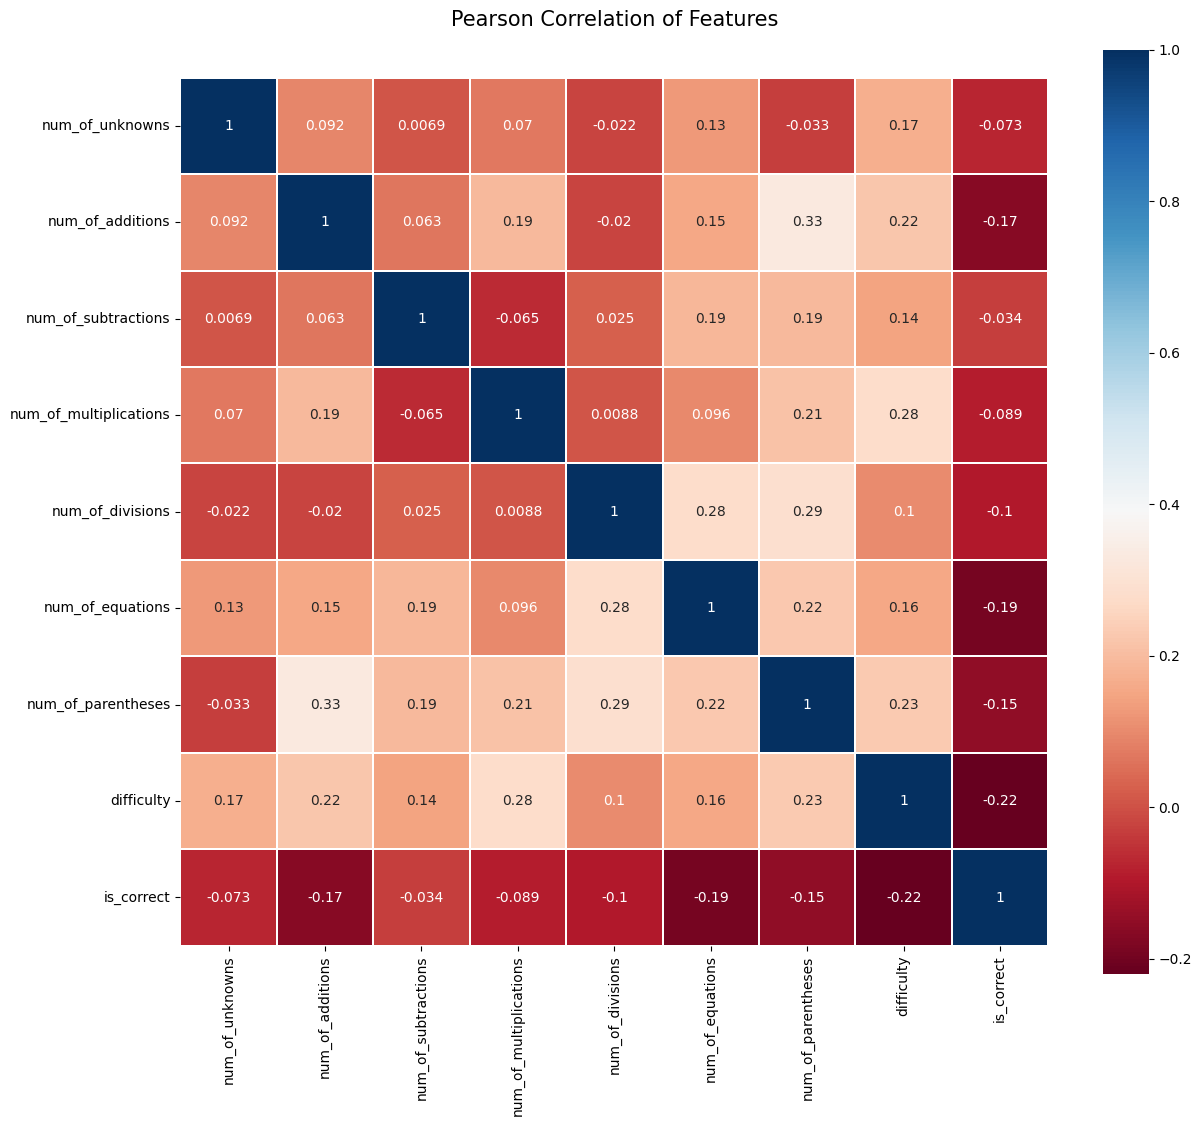

In [15]:
if VISUALIZE_DATA:
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    seaborn.heatmap(model_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)

### **Scatter plot matrix**

In [16]:
if VISUALIZE_DATA:
    fig = px.scatter_matrix(evaluated_df,
                            dimensions=[
                                "num_of_unknowns",
                                "num_of_additions",
                                "num_of_subtractions",
                                "num_of_multiplications",
                                "num_of_divisions",
                                "num_of_equations",
                                "num_of_parentheses",
                                "difficulty",
                                "final_solved_same"],
                            color="normal_correct")
    fig.update_layout(
        title='ChatGPT response',
        dragmode='select',
        width=1600,
        height=1600,
        hovermode='closest',
    )
    fig.show()


In [17]:
labels = list(model_df.columns.drop(labels=['is_correct']))
groups = model_df.groupby(labels)['is_correct'].mean()

print("NUMBER OF GROUPS:", len(groups))
groups.head()

NUMBER OF GROUPS: 576


num_of_unknowns  num_of_additions  num_of_subtractions  num_of_multiplications  num_of_divisions  num_of_equations  num_of_parentheses  difficulty
1.0              0.0               0.0                  0.0                     0.0               1.0               0.0                 2.0           1.0
                                                                                                  3.0               0.0                 3.0           0.0
                                                                                3.0               1.0               0.0                 3.0           0.0
                                                                                6.0               3.0               3.0                 3.0           1.0
                                                        1.0                     0.0               3.0               0.0                 4.0           1.0
Name: is_correct, dtype: float64

### **Predict ChatGPT's success using ML models**
We attempt to predict ChatGPT's success in solving math word problems based on features extracted from its response.

#### **Split data into train and test sets**

In [18]:
train, test = train_test_split(model_df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

train_x = train.drop(columns=["is_correct"])
test_x = test.drop(columns=["is_correct"])

train_y = train["is_correct"]
test_y = test[["is_correct"]]

display(train_x.head())
display(train_y.head())

,num_of_unknowns,num_of_additions,num_of_subtractions,num_of_multiplications,num_of_divisions,num_of_equations,num_of_parentheses,difficulty
77,2.0,2.0,0.0,0.0,0.0,3.0,0.0,3.0
249,2.0,2.0,0.0,2.0,0.0,4.0,4.0,3.0
252,2.0,1.0,0.0,2.0,0.0,2.0,0.0,4.0
82,2.0,1.0,0.0,1.0,0.0,2.0,2.0,4.0
553,2.0,3.0,0.0,1.0,0.0,2.0,2.0,5.0


77     0
249    0
252    1
82     0
553    0
Name: is_correct, dtype: int64

### **Sklearn Helper**
This is just a utility class which wraps all needed functions for Sklearn models

In [19]:
# =========================================== #
#    Sklearn Helper
# =========================================== #
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params={}):
        self.clf = clf
        self.params = params

    def fit(self, x_train, y_train):
        self.fitted = self.clf(**self.params).fit(x_train, y_train)
    
    def predict(self, x):
        return self.fitted.predict(x)
    
    def feature_importance(self):
        return self.fitted.feature_importances_
    
    def tune(self, x_train, y_train, params=None):
        
        grid = GridSearchCV(self.clf(), param_grid=params)
        grid.fit(x_train, y_train)

        self.params = grid.best_params_

        print(self.params)
        pass

### **Tensorflow Helper**
This is just a utility class which wraps all needed functions for Tensorflow models

In [20]:
# =========================================== #
#    TF Helper
# =========================================== #
class TFHelper(object):
    def __init__(self, clf, seed=0, params={}):
        self.clf = clf

    def fit(self, x_train, y_train):
        self.fitted = self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        # return list(self.clf.predict(x))
        return [list(prediction).index(max(list(prediction))) for prediction in list(self.clf.predict(x))]
    
    def feature_importance(self):
        return self.fitted.feature_importances_
    
    def tune(self, x_train, y_train, params=None):
        pass

### **Cross-validate models**
We evaluate our model performance across 5 folds and find the average

In [21]:
# =========================================== #
#    Cross-validate models
# =========================================== #
def cross_validate(model, x_data, y_data, n_splits, random_state=42, shuffle=True):
    cross_fold = KFold(n_splits, random_state=random_state, shuffle=shuffle)

    cross_validation_results = []
    for i, (train_index, test_index) in enumerate(cross_fold.split(x_data)):
        x_train, y_train = x_data.iloc[train_index], y_data.iloc[train_index]
        x_test, y_test = x_data.iloc[test_index], y_data.iloc[test_index]

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        report = classification_report(y_test, y_pred, target_names=list(set(answer_map.values())), output_dict=True)
        cross_validation_results.append(report)

    average_results = {}
    for result in cross_validation_results:
        for key1 in list(set(answer_map.values())):
            average_results[key1] = {}
            for key2 in ['precision', 'recall', 'f1-score', 'support']:
                average_results[key1][key2] = 0

    for result in cross_validation_results:
        for key1 in list(set(answer_map.values())):
            for key2 in ['precision', 'recall', 'f1-score', 'support']:
                average_results[key1][key2] += result[key1][key2]
    
    for key1 in list(set(answer_map.values())):
        for key2 in ['precision', 'recall', 'f1-score', 'support']:
            average_results[key1][key2] /= n_splits
        
    return pandas.DataFrame(average_results)

def cross_validate_model(classifier):
    return cross_validate(classifier, train_x, train_y, N_SPLITS, RANDOM_STATE, True)

### **Random Forest**

In [22]:
# =========================================== #
#    Random Forest
# =========================================== #
random_forest = SklearnHelper(RandomForestClassifier)

random_forest.tune(train_x, train_y, params={
    "random_state" : [RANDOM_STATE]
    # 'n_jobs': [-1],
    # 'n_estimators': [10],
    # 'max_depth': [6],
    # 'min_samples_leaf': [2],
    # 'max_features': ['sqrt'],
    # 'verbose': [0],
    # 'class_weight': ['balanced_subsample']
}
)

pandas.DataFrame(cross_validate_model(random_forest))

{'random_state': 42}


,0,1
precision,0.729423,0.532042
recall,0.764368,0.487871
f1-score,0.745295,0.506135
support,97.600000,53.600000


### **XGBoost**

In [23]:
# =========================================== #
#    XGBoost
# =========================================== #
xgboost = SklearnHelper(XGBClassifier, seed=RANDOM_STATE)

xgboost.tune(train_x, train_y, params={
    "random_state" : [RANDOM_STATE]
    # 'n_jobs': [-1],
    # 'n_estimators': [10],
    # 'max_depth': [6],
    # 'min_samples_leaf': [2],
    # 'max_features': ['sqrt'],
    # 'verbose': [0],
    # 'class_weight': ['balanced_subsample']
}
)

cross_validate_model(xgboost)

{'random_state': 42}


,0,1
precision,0.718429,0.492083
recall,0.719393,0.493536
f1-score,0.718004,0.491078
support,97.600000,53.600000


### **Gradient Boost**

In [24]:
# =========================================== #
#    Gradient Boost
# =========================================== #
gradient_boost = SklearnHelper(GradientBoostingClassifier, seed=RANDOM_STATE)

gradient_boost.tune(train_x, train_y, params={
    "random_state": [RANDOM_STATE]
    # 'n_jobs': [-1],
    # 'n_estimators': [10],
    # 'max_depth': [6],
    # 'min_samples_leaf': [2],
    # 'max_features': ['sqrt'],
    # 'verbose': [0],
    # 'class_weight': ['balanced_subsample']
}
)

cross_validate_model(gradient_boost)


{'random_state': 42}


,0,1
precision,0.703764,0.515054
recall,0.787354,0.400631
f1-score,0.741661,0.445983
support,97.600000,53.600000


### **KMeans**

In [25]:
# =========================================== #
#    KMeans
# =========================================== #
kmeans = SklearnHelper(KMeans, params={
    "n_clusters": len(set(answer_map.values())),
    "random_state": RANDOM_STATE
})
cross_validate_model(kmeans)

,0,1
precision,0.727985,0.354681
recall,0.487807,0.576708
f1-score,0.554393,0.424571
support,97.600000,53.600000


### **Feature importances**

In [26]:
# =========================================== #
#    Feature importances
# =========================================== #
    
# ------------------------------------------- #
#   Function which visualizes feature
#   importance
# ------------------------------------------- #
def show_feature_importance(model, name):
    trace = go.Scatter(
        y = model.feature_importance(),
        x = train_x.columns.values,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
    #       size= feature_dataframe['AdaBoost feature importances'].values,
            #color = np.random.randn(500), #set color equal to a variable
            color = model.feature_importance(),
            colorscale='Portland',
            showscale=True
        ),
        text = train_x.columns.values
    )
    data = [trace]
    layout= go.Layout(
        autosize= True,
        hovermode= 'closest',
        yaxis=dict(
            title= f'{name} Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        title= f'{name} Feature Importance',
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig,filename='scatter2010')

In [27]:
show_feature_importance(random_forest, "Random Forest")
show_feature_importance(xgboost, "XGBoost")
show_feature_importance(gradient_boost, "Gradient Boost")

### **Tensorflow Sequential Model**

In [28]:
sequential_model = keras.Sequential(
    [
        layers.Dense(128, activation="relu"),
        layers.Dense(2, activation="relu"),
    ]
)

sequential_model.compile(
    optimizer=keras.optimizers.RMSprop(),  
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.RootMeanSquaredError()],
)

sequential_model = TFHelper(sequential_model)
cross_validate_model(sequential_model)

19/19 [==============================] - 0s 1ms/step - loss: 3.2582 - root_mean_squared_error: 0.5504


c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



19/19 [==============================] - 0s 944us/step - loss: 3.2339 - root_mean_squared_error: 0.5457


c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



19/19 [==============================] - 0s 1ms/step - loss: 3.2210 - root_mean_squared_error: 0.5461


c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



19/19 [==============================] - 0s 1ms/step - loss: 2.9430 - root_mean_squared_error: 0.5232


c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



5/5 [==============================] - 0s 752us/step


c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nocet\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,0,1
precision,0.645512,0.0
recall,1.000000,0.0
f1-score,0.783363,0.0
support,97.600000,53.6
